# Processing MMU iris dataset

## Loading drive by mounting all the content in /google_drive directory

In [ ]:
# Importing drive API
from google.colab import drive
# Creating a directory in the root dir to mount the cloud drive (! is for executing shell commands)
!mkdir /Google_drive
# Mounting the drive and force remounting if already mounted
drive.mount('/Google_drive', force_remount=True)
!cd /Google_drive/Shareddrives ; ls

Mounted at /Google_drive


## Loading the images

In [ ]:
image_dir = '/Google_drive/MyDrive/SD_card_synced/Test Images/images'
# importing the os module which gives access to os api to walk through the directory
import os
for dirpath, dirname, filenames in os.walk(image_dir):
    print(f"Current directory is : {dirpath}")
    print(f"    Total files in {dirpath} : {len(filenames)} files")
    for filename in filenames:
        print(f"    Found : {os.path.join(dirpath, filename)}")

Current directory is : /Google_drive/MyDrive/SD_card_synced/Test Images/images
    Total files in /Google_drive/MyDrive/SD_card_synced/Test Images/images : 450 files
    Found : /Google_drive/MyDrive/SD_card_synced/Test Images/images/zaridahl2.jpg
    Found : /Google_drive/MyDrive/SD_card_synced/Test Images/images/mimil4.jpg
    Found : /Google_drive/MyDrive/SD_card_synced/Test Images/images/ongbll3.jpg
    Found : /Google_drive/MyDrive/SD_card_synced/Test Images/images/mimir4.jpg
    Found : /Google_drive/MyDrive/SD_card_synced/Test Images/images/mimir1.jpg
    Found : /Google_drive/MyDrive/SD_card_synced/Test Images/images/ongbll4.jpg
    Found : /Google_drive/MyDrive/SD_card_synced/Test Images/images/zaridahr2.jpg
    Found : /Google_drive/MyDrive/SD_card_synced/Test Images/images/zaridahr4.jpg
    Found : /Google_drive/MyDrive/SD_card_synced/Test Images/images/ongbll2.jpg
    Found : /Google_drive/MyDrive/SD_card_synced/Test Images/images/mimir3.jpg
    Found : /Google_drive/MyDriv

## Reading the image using open computer vison module in python

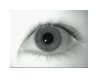

In [ ]:
import cv2
# We need to import matplotlib as cv2 plotting can't be viewed in jupyter notebooks
# In particular the matplotlib.pyplot method, also you can set the style as you wish
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# First image has to be stored in an image object
image = cv2.imread('/Google_drive/MyDrive/SD_card_synced/Test Images/images/aeval1.jpg')
# Convert BGR to RGB for proper display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Create the image object to be shown
plt.figure(figsize=(1,1))
plt.imshow(image)
# Turn off axis as it is an image
plt.axis('off')
# Now just show the image
plt.show()

## Viewing and manipulating images

In [ ]:
# A shorter way to list files using list comprehension
files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
# Reducing the number of images by slicing the list
files = files[0:400]

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Assuming you have your image directory and files list ready
# image_dir = "/Google_drive/MyDrive/SD_card_synced/images/"
files = os.listdir(image_dir)

# Create a figure and a set of subplots (20 rows and 20 columns)
fig, axs = plt.subplots(nrows=20, ncols=20, figsize=(20, 20))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the images and display each in a subplot
for i in range(min(len(files), 400)):  # Limit to 400 files for the 20x20 grid
    image_path = os.path.join(image_dir, files[i])

    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    height, width = image.shape

    # Define how much to shave/crop from the bottom (e.g., 100 pixels)
    crop_height = 7

    # Crop the bottom part of the image
    image = image[:height - crop_height, :]

    if image is not None:
        pixels = image.flatten()
        lowest_intensities = np.partition(pixels, 20)[:20]
        variance = np.var(lowest_intensities)
        std_deviation = np.std(lowest_intensities)

        weight=5

        # Find the minimum intensity (lowest intensity pixel value)
        min_intensity = np.min(image)
        min_intensity+=variance
        min_intensity+=weight
        # Find the minimum intensity and threshold it
        # min_intensity = np.min(image) + 2
        # Get the coordinates of all pixels with the minimum intensity
        coords = np.column_stack(np.where(image < min_intensity))

        # Find the leftmost and rightmost coordinates
        leftmost = coords[np.argmin(coords[:, 1])]  # Leftmost pixel
        rightmost = coords[np.argmax(coords[:, 1])]  # Rightmost pixel

        # Mark the leftmost and rightmost points on the image for visualization
        image_with_points = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR for colored markings
        cv2.circle(image_with_points, (leftmost[1], leftmost[0]), 5, (0, 0, 255), -1)  # Red circle for leftmost
        cv2.circle(image_with_points, (rightmost[1], rightmost[0]), 5, (255, 0, 0), -1)  # Blue circle for rightmost

        # Convert BGR image to RGB for displaying in matplotlib
        image_with_points_rgb = cv2.cvtColor(image_with_points, cv2.COLOR_BGR2RGB)

        # Display the image in the corresponding subplot
        axs[i].imshow(image_with_points_rgb)
        axs[i].axis('off')  # Turn off the axis for a cleaner look
        # axs[i].set_title(f"Image {i+1}")
    else:
        print(f"Failed to load image {files[i]}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the entire grid of images
plt.show()


## Looking at image properties

In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math

def process_image(image_path):
    """
    Processes an image using Daugman's algorithm-inspired techniques
    to demarcate pupil, iris, and sclera.
    Returns the processed image with demarcation.
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    # Step 1: Use Gaussian Blur to remove noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Step 2: Apply adaptive threshold to highlight features
    _, threshold_image = cv2.threshold(blurred_image, 50, 255, cv2.THRESH_BINARY_INV)

    # Step 3: Find contours to locate the pupil
    contours, _ = cv2.findContours(threshold_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Step 4: Use the largest contour to find the pupil
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        center = (int(x), int(y))
        radius = int(radius)
    else:
        # If no contours are found, skip this image
        print(f"No contours found for {image_path}. Skipping...")
        return None

    # Draw the pupil circle on the original image
    pupil_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.circle(pupil_image, center, radius, (0, 255, 0), 2)  # Draw green circle for pupil

    # Step 5: Use KMeans clustering to segment the iris and sclera
    reshaped_image = image.reshape((-1, 1))
    reshaped_image = np.float32(reshaped_image)

    # Define criteria and apply KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=0)
    labels = kmeans.fit_predict(reshaped_image)

    segmented_image = labels.reshape(image.shape)

    # The cluster with the smallest intensity corresponds to the pupil, others are iris and sclera
    pupil_cluster = np.argmin(kmeans.cluster_centers_)
    iris_cluster = np.median(kmeans.cluster_centers_)

    # Create a mask for pupil and iris
    pupil_mask = (segmented_image == pupil_cluster).astype(np.uint8) * 255
    iris_mask = (segmented_image == iris_cluster).astype(np.uint8) * 255

    # Overlay the masks on the original image for demarcation
    segmented_result = np.zeros_like(pupil_image)
    segmented_result[pupil_mask == 255] = [0, 255, 0]   # Green for pupil
    segmented_result[iris_mask == 255] = [255, 0, 0]    # Blue for iris

    # Combine all the masks and display the sclera (in white)
    sclera_mask = (segmented_image != pupil_cluster) & (segmented_image != iris_cluster)
    segmented_result[sclera_mask] = [255, 255, 255]     # White for sclera

    # Combine original and segmented images
    combined = cv2.addWeighted(pupil_image, 0.7, segmented_result, 0.3, 0)

    return combined

def process_images_in_directory(directory, num_images_per_row=6):
    """
    Walks through the directory, processes all images, and displays results in subplots.
    """
    images_to_process = []

    # Load and process each image in the directory
    for root, _, files in os.walk(directory):
        for file in files:
            image_path = os.path.join(root, file)
            print(f"Processing {image_path}...")
            processed_image = process_image(image_path)
            if processed_image is not None:
                images_to_process.append((file, processed_image))

    # Determine the number of rows and columns for subplots
    num_images = len(images_to_process)
    num_rows = math.ceil(num_images / num_images_per_row)

    # Set up the subplot grid
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(20, num_rows * 4))
    axes = axes.ravel()  # Flatten to make indexing easier

    # Loop through the images and plot them in the grid
    for idx, (file_name, img) in enumerate(images_to_process):
        axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[idx].set_title(file_name)
        axes[idx].axis('off')

    # Hide any remaining empty subplots
    for idx in range(num_images, num_rows * num_images_per_row):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
directory = '/Google_drive/MyDrive/SD_card_synced/Test Images/images/'  # Update this to the path containing 400 images
process_images_in_directory(directory, num_images_per_row=10)


In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [ ]:
# Install TensorFlow and Keras for Deep Learning
!pip install tensorflow keras

# Install OpenCV for image processing
!pip install opencv-python

# Install dlib for facial landmark detection (optional but useful for preprocessing)
!pip install dlib

# Clone the DeepGaze repo (if needed for specific deep gaze models)
# !git clone https://github.com/mpatacchiola/deepgaze.git


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


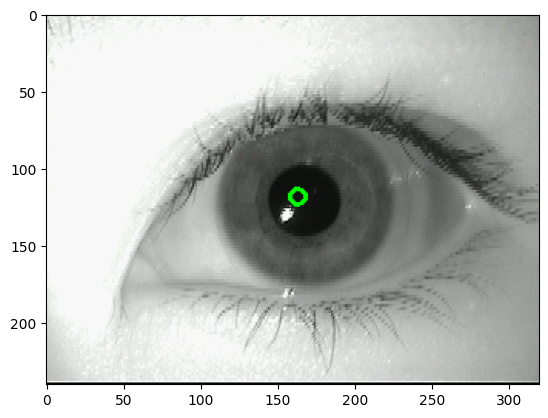

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Function to preprocess the eye image (this is a simplification for demonstration)
def preprocess_image(image, target_size=(64, 64)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, target_size)
    return resized / 255.0  # Normalize the image

# Example CNN model for iris/pupil detection
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2, activation='sigmoid')  # Output 2 values: x and y coordinates of the pupil
    ])

    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])
    return model

# Load an example dataset (You need to replace this with your real dataset)
# For simplicity, you can use synthetic images or datasets like UnityEyes or GazeCapture
# Here, we use a placeholder image
image_path = "/Google_drive/MyDrive/SD_card_synced/Test Images/images/aeval2.jpg"
image = cv2.imread(image_path)

# Preprocess the image
processed_image = preprocess_image(image)
processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension

# Build and train the model (replace this with your dataset training step)
model = build_model()

# Example training loop (replace with real dataset)
# X_train, y_train = load_your_dataset()
# model.fit(X_train, y_train, epochs=10, batch_size=32)

# For demonstration, we're skipping the training part and assuming the model is trained
# Pupil detection (the output would be [x, y] coordinates in normalized form)
pupil_coords = model.predict(processed_image)

# Post-process the predicted coordinates to draw them on the image
pupil_x = int(pupil_coords[0][0] * image.shape[1])
pupil_y = int(pupil_coords[0][1] * image.shape[0])

# Draw a circle at the predicted pupil coordinates
cv2.circle(image, (pupil_x, pupil_y), 5, (0, 255, 0), 2)

# Display the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

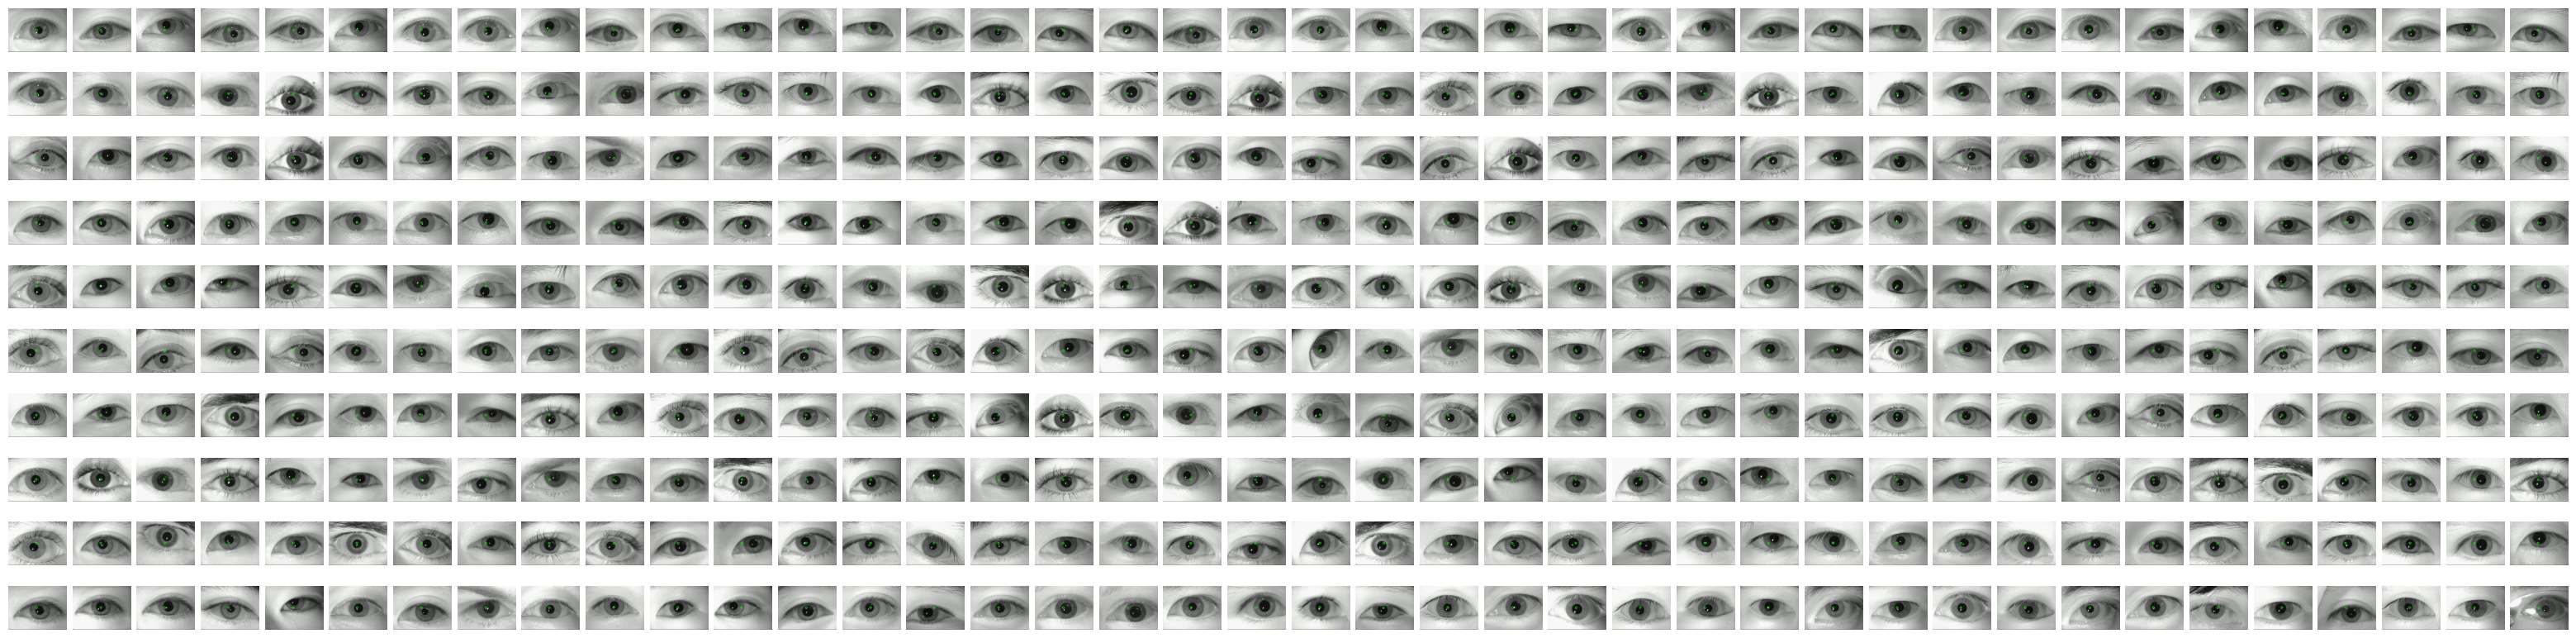

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Function to preprocess the eye image (grayscale conversion and resizing)
def preprocess_image(image, target_size=(64, 64)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, target_size)
    return resized / 255.0  # Normalize the image

# Example CNN model for iris/pupil detection
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2, activation='sigmoid')  # Output 2 values: x and y coordinates of the pupil
    ])

    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])
    return model

# Path to the directory containing images
image_directory = "/Google_drive/MyDrive/SD_card_synced/Test Images/images/"

# Build the model
model = build_model()

# For demonstration purposes, we assume the model is pre-trained
# Replace with actual training or loading a pre-trained model

# Initialize a figure for the subplot with a size that fits 10x40 images
fig, axes = plt.subplots(10, 40, figsize=(40, 10))

# Flatten axes for easier indexing
axes = axes.flatten()

# Counter to track how many images have been processed
image_count = 0

# Loop through all images in the directory
for filename in os.listdir(image_directory):
    if (filename.endswith(".jpg") or filename.endswith(".png")) and image_count < 400:  # Process up to 400 images
        image_path = os.path.join(image_directory, filename)
        image = cv2.imread(image_path)

        # Preprocess the image
        processed_image = preprocess_image(image)
        processed_image = np.expand_dims(processed_image, axis=-1)  # Add channel dimension (64, 64, 1)
        processed_image = np.expand_dims(processed_image, axis=0)   # Add batch dimension (1, 64, 64, 1)

        # Predict pupil coordinates
        pupil_coords = model.predict(processed_image)

        # Post-process the predicted coordinates to draw them on the image
        pupil_x = int(pupil_coords[0][0] * image.shape[1])  # x-coordinate
        pupil_y = int(pupil_coords[0][1] * image.shape[0])  # y-coordinate

        # Draw a circle at the predicted pupil coordinates
        cv2.circle(image, (pupil_x, pupil_y), 5, (0, 255, 0), 2)

        # Convert image to RGB for plotting
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Plot the processed image on the corresponding subplot
        axes[image_count].imshow(rgb_image)
        axes[image_count].axis('off')  # Turn off axis labels for better clarity

        # Increment the counter
        image_count += 1

    if image_count == 400:  # Stop once 400 images are processed
        break

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import cv2
import numpy as np

image_paths = '/Google_drive/MyDrive/SD_card_synced/Test Images/images/'

# Define a simple U-Net-like architecture for segmentation
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.encoder_layers = list(self.encoder.children())[:-2]
        self.encoder = nn.Sequential(*self.encoder_layers)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=1),
            nn.Sigmoid()  # For binary segmentation mask
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Dataset preparation (simplified)
class EyeDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images  # List of image file paths
        self.masks = masks    # List of corresponding segmentation masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask

# Load data and prepare for training
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))])
train_dataset = EyeDataset(image_paths, mask_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Model, Loss, Optimizer
model = UNet()
criterion = nn.BCELoss()  # Binary cross-entropy for segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Post-processing: Hough Circle Transform to find circles
def find_circles(image, mask):
    circles = []
    for i in range(2):  # For iris and pupil
        masked_img = cv2.bitwise_and(image, image, mask=mask[i])
        gray = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
        detected_circles = cv2.HoughCircles(
            gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
            param1=50, param2=30, minRadius=20, maxRadius=100
        )
        if detected_circles is not None:
            circles.append(detected_circles[0, 0])  # Add detected circle (x, y, r)
    return circles

NameError: name 'mask_paths' is not defined

In [ ]:
oimport cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

# Function to process a single image and return processed results
def process_image(image_path, pixels_to_shave=10, radius=80, weight=5, k=3):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image {image_path}.")
        return None

    # Shave the image boundaries
    image = image[:-pixels_to_shave, :]

    # Compute the center coordinates
    height, width = image.shape
    center_y, center_x = height // 2, width // 2

    # Create a mask for the circular region around the center
    y, x = np.indices((height, width))
    mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2

    # Apply the mask to the image
    masked_pixels = image[mask]

    # Compute variance and standard deviation of the masked pixels
    pixels = image.flatten()
    lowest_intensities = np.partition(pixels, 20)[:60]
    variance = np.var(lowest_intensities)

    # Calculate minimum intensity to compare with
    min_intensity = np.min(masked_pixels) + variance + weight

    # Get the coordinates of all pixels within the mask with the minimum intensity
    coords = np.column_stack(np.where((image < min_intensity) & mask))

    # If there are valid coordinates, proceed with processing
    if len(coords) > 0:
        leftmost = coords[np.argmin(coords[:, 1])]
        rightmost = coords[np.argmax(coords[:, 1])]
        topmost = coords[np.argmin(coords[:, 0])]
        bottommost = coords[np.argmax(coords[:, 0])]

        # Define center and find closest points
        center = np.array([height // 2, width // 2])
        def distance_from_center(point, center):
            return np.linalg.norm(point - center)

        # Closest points in vertical and horizontal direction
        top_bottom_points = np.array([topmost, bottommost])
        closest_vertical = top_bottom_points[np.argmin([distance_from_center(p, center) for p in top_bottom_points])]

        left_right_points = np.array([leftmost, rightmost])
        closest_horizontal = left_right_points[np.argmin([distance_from_center(p, closest_vertical) for p in left_right_points])]

        # Extract pixel row and apply KMeans
        pixel_array = image[closest_horizontal[0], :].reshape(-1, 1)
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(pixel_array)
        labels = kmeans.labels_

        label_of_interest = labels[closest_vertical[1]]
        iris_indices = np.where(labels == label_of_interest)
        iris_index_first = iris_indices[0][0]
        iris_index_last = iris_indices[0][-1]
        ind = iris_index_last if iris_index_last - closest_vertical[1] < closest_vertical[1] - iris_index_first else iris_index_first
        centre_coord = int((closest_vertical[1] + ind) / 2)
        iris_rad = min(iris_index_last - closest_vertical[1], closest_vertical[1] - iris_index_first)
        diff = abs((closest_vertical[0] - closest_horizontal[0])) - abs((closest_horizontal[1] - closest_vertical[1]))
        diff *= 1 if (closest_vertical[0] - closest_horizontal[0]) > (closest_horizontal[1] - closest_vertical[1]) else -1

        # Mark points and circle
        image_with_points = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.circle(image_with_points, (leftmost[1], leftmost[0]), 5, (0, 0, 255), -1)
        cv2.circle(image_with_points, (rightmost[1], rightmost[0]), 5, (255, 0, 0), -1)
        cv2.circle(image_with_points, (topmost[1], topmost[0]), 5, (0, 255, 0), -1)
        cv2.circle(image_with_points, (bottommost[1], bottommost[0]), 5, (0, 0, 255), -1)
        cv2.circle(image_with_points, (closest_vertical[1], closest_horizontal[0]), 5, (255, 0, 255), -1)
        cv2.circle(image_with_points, (center_x, center_y), 5, (255, 255, 255), -1)
        cv2.circle(image_with_points, (closest_vertical[1] + int(diff / 2), closest_horizontal[0]), iris_rad, (255, 255, 255), 1)

        return cv2.cvtColor(image_with_points, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting
    return None

# Directory containing the images
image_dir = '/Google_drive/MyDrive/SD_card_synced/Test Images/images'

# Get list of all images in the directory
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.jpg')]

# Setup plot
fig, axes = plt.subplots(20, 20, figsize=(20, 20))
axes = axes.flatten()

# Process each image and plot on the 20x20 subplot
for idx, image_file in enumerate(image_files[:400]):
    processed_image = process_image(image_file)
    if processed_image is not None:
        axes[idx].imshow(processed_image)
        axes[idx].axis('off')
    else:
        print(f"Skipping image {image_file} due to processing issues.")

# Show the final plot
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Function to fit a circle through three points
def fit_circle_through_points(p1, p2, p3):
    temp = p2[0]**2 + p2[1]**2
    bc = (p1[0]**2 + p1[1]**2 - temp) / 2
    cd = (temp - p3[0]**2 - p3[1]**2) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])
    if abs(det) < 1.0e-6:
        raise ValueError("Points are collinear")

    cx = (bc * (p2[1] - p3[1]) - cd * (p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det
    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)

    return (int(cx), int(cy)), int(radius)

# Resize images for faster processing
def resize_image(image, target_size=(128, 128)):
    return cv2.resize(image, target_size)

# Process a single image (loading, resizing, fitting circle)
def process_image(image_file):
    try:
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = resize_image(image_rgb)

        height, width = image_resized.shape[:2]
        p1 = (width // 4, height // 2)
        p2 = (width // 2, height // 4)
        p3 = (3 * width // 4, height // 2)

        (cx, cy), radius = fit_circle_through_points(p1, p2, p3)

        # Draw the circle and points
        cv2.circle(image_resized, (cx, cy), radius, (255, 0, 0), 2)
        cv2.circle(image_resized, p1, 5, (0, 255, 0), -1)
        cv2.circle(image_resized, p2, 5, (0, 255, 0), -1)
        cv2.circle(image_resized, p3, 5, (0, 255, 0), -1)

        return image_resized

    except Exception as e:
        print(f"Error processing image {image_file}: {e}")
        return None

# Directory containing eye images
image_dir = '/Google_drive/MyDrive/SD_card_synced/Test Images/images'
output_dir = '/Google_drive/MyDrive/SD_card_synced/'

# Get list of images
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Process images using parallel threadsithub.com/
with ThreadPoolExecutor() as executor:
    processed_images = list(executor.map(process_image, image_files[:400]))

# Create a figure for 20x20 subplots
fig, axes = plt.subplots(nrows=20, ncols=20, figsize=(40, 40))
axes = axes.ravel()

# Plot processed images
for idx, image_resized in enumerate(processed_images):
    if image_resized is not None:
        axes[idx].imshow(image_resized)
        axes[idx].axis('off')

plt.tight_layout()

# Save the high-resolution plot
plt.savefig(os.path.join(output_dir, 'iris_detection_grid.png'), dpi=300)
plt.show()


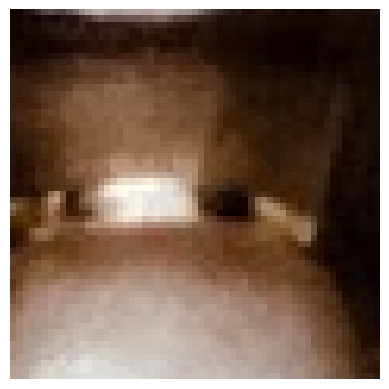

In [10]:
# Step 1: Install OpenCV
!pip install opencv-python

# Step 2: Import the necessary libraries
import cv2
import matplotlib.pyplot as plt

# Step 3: Load the face image
# You can replace 'path_to_image' with the actual path to the image file.
image_path = '/content/one_image_to_process.jpeg'  # Update with your image path
image = cv2.imread(image_path)

# Convert the image to grayscale (necessary for eye detection)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 4: Load Haar Cascade for eye detection
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Step 5: Detect eyes in the image
eyes = eye_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=10, minSize=(30, 30))

# Step 6: Draw rectangles around the eyes and crop the image
if len(eyes) > 0:
    for (x, y, w, h) in eyes:
        # Crop the image to the detected eye region
        eye_image = image[y:y+h, x:x+w]

        # Display each eye region
        plt.imshow(cv2.cvtColor(eye_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Hide axes
        plt.show()
else:
    print("No eyes detected!")

# Step 7: Optional - Save the cropped eye images
# cv2.imwrite('cropped_eye.jpg', eye_image)  # Uncomment if you want to save the cropped images


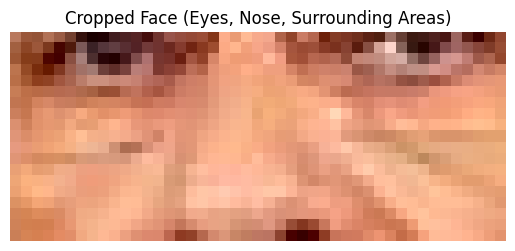

In [13]:
# Step 1: Install the required libraries
# !pip install mediapipe opencv-python tensorflow

# Step 2: Import necessary libraries
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Step 3: Initialize MediaPipe Face Mesh and drawing utilities
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Step 4: Load the image
image_path = '/content/second_image.jpeg'  # Update with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 5: Initialize Face Mesh Model
with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
    # Step 6: Process the image and detect facial landmarks
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        # Access the facial landmarks
        face_landmarks = results.multi_face_landmarks[0]

        # Step 7: Define key landmark indices (eyes, nose, etc.)
        left_eye_indices = [33, 133, 144, 145, 153, 154, 155, 163]  # Left eye
        right_eye_indices = [263, 362, 373, 374, 380, 381, 382, 390]  # Right eye
        nose_tip_index = 1  # Nose tip landmark

        # Step 8: Extract eye and nose landmarks
        left_eye_coords = np.array([(int(face_landmark.x * image.shape[1]), int(face_landmark.y * image.shape[0]))
                                    for i, face_landmark in enumerate(face_landmarks.landmark) if i in left_eye_indices])

        right_eye_coords = np.array([(int(face_landmark.x * image.shape[1]), int(face_landmark.y * image.shape[0]))
                                    for i, face_landmark in enumerate(face_landmarks.landmark) if i in right_eye_indices])

        nose_tip_coord = (int(face_landmarks.landmark[nose_tip_index].x * image.shape[1]),
                          int(face_landmarks.landmark[nose_tip_index].y * image.shape[0]))

        # Step 9: Calculate bounding box that includes eyes and part of the nose/mouth
        def expanded_bounding_box(eye_coords, nose_coord, expansion_ratio=1.5):
            x_min = np.min(eye_coords[:, 0])
            y_min = np.min(eye_coords[:, 1])
            x_max = np.max(eye_coords[:, 0])
            y_max = np.max(eye_coords[:, 1])

            # Find the center of the eye region
            center_x = (x_min + x_max) // 2
            center_y = (y_min + y_max) // 2

            # Expand the bounding box to include more parts of the face
            width = int((x_max - x_min) * expansion_ratio)
            height = int((y_max - y_min) * expansion_ratio)

            # Define new bounding box with some margin around the eyes
            x_min_expanded = max(center_x - width // 2, 0)
            y_min_expanded = max(center_y - height // 2, 0)
            x_max_expanded = min(center_x + width // 2, image.shape[1])
            y_max_expanded = min(nose_coord[1] + height // 2, image.shape[0])

            return x_min_expanded, y_min_expanded, x_max_expanded, y_max_expanded

        # Get expanded bounding box for eyes and part of the nose/mouth
        left_eye_box = expanded_bounding_box(left_eye_coords, nose_tip_coord)
        right_eye_box = expanded_bounding_box(right_eye_coords, nose_tip_coord)

        # Step 10: Merge left and right eye boxes to include a larger region
        overall_x_min = min(left_eye_box[0], right_eye_box[0])
        overall_y_min = min(left_eye_box[1], right_eye_box[1])
        overall_x_max = max(left_eye_box[2], right_eye_box[2])
        overall_y_max = max(left_eye_box[3], right_eye_box[3])

        # Step 11: Crop the image to the expanded face region
        expanded_face_image = image[overall_y_min:overall_y_max, overall_x_min:overall_x_max]

        # Step 12: Display the cropped face region (eyes, nose, etc.)
        plt.imshow(cv2.cvtColor(expanded_face_image, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Face (Eyes, Nose, Surrounding Areas)")
        plt.axis('off')
        plt.show()

    else:
        print("No face detected!")


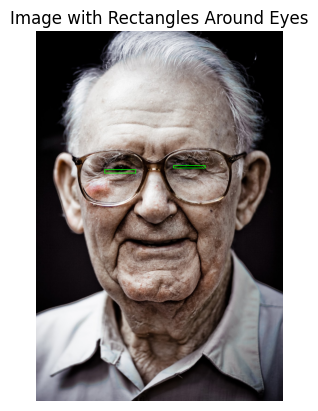

In [15]:
# Step 1: Install the required libraries
!pip install mediapipe opencv-python tensorflow

# Step 2: Import necessary libraries
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Step 3: Initialize MediaPipe Face Mesh and drawing utilities
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Step 4: Load the image
image_path = '/content/one_image_to_process.jpeg'  # Update with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 5: Initialize Face Mesh Model
with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
    # Step 6: Process the image and detect facial landmarks
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        # Access the facial landmarks
        face_landmarks = results.multi_face_landmarks[0]

        # Step 7: Define eye landmark indices (these are based on MediaPipe's face mesh model)
        left_eye_indices = [33, 133, 144, 145, 153, 154, 155, 163]  # Left eye
        right_eye_indices = [263, 362, 373, 374, 380, 381, 382, 390]  # Right eye

        # Extract left eye landmarks
        left_eye_coords = np.array([(int(face_landmark.x * image.shape[1]), int(face_landmark.y * image.shape[0]))
                                    for i, face_landmark in enumerate(face_landmarks.landmark) if i in left_eye_indices])

        # Extract right eye landmarks
        right_eye_coords = np.array([(int(face_landmark.x * image.shape[1]), int(face_landmark.y * image.shape[0]))
                                    for i, face_landmark in enumerate(face_landmarks.landmark) if i in right_eye_indices])

        # Step 8: Calculate bounding boxes for both eyes
        def bounding_box(eye_coords):
            x_min = np.min(eye_coords[:, 0])
            y_min = np.min(eye_coords[:, 1])
            x_max = np.max(eye_coords[:, 0])
            y_max = np.max(eye_coords[:, 1])
            return x_min, y_min, x_max, y_max

        # Get bounding boxes for both eyes
        left_eye_box = bounding_box(left_eye_coords)
        right_eye_box = bounding_box(right_eye_coords)

        # Step 9: Draw rectangle around the eyes
        def draw_rectangle(image, box, color=(0, 255, 0), thickness=2):
            x_min, y_min, x_max, y_max = box
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

        # Draw rectangles for both eyes on the original image
        draw_rectangle(image, left_eye_box)
        draw_rectangle(image, right_eye_box)

        # Step 10: Display the image with rectangles around the eyes
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Image with Rectangles Around Eyes")
        plt.axis('off')  # Hide the axis
        plt.show()

    else:
        print("No face detected!")
